# Example light curve fits, for small samples

BayeSN has been designed for doing hierarchical inference and light curve fits with large SN samples, leveraging GPU acceleration and vectorisation for efficient computation. However, in many cases you may want to run a small number of fits within an accessible Python script rather than deploying large jobs to a cluster.

As an alternative to BayeSN's yaml configuration, it is possible to do much simpler single light curve fits within a Python script/Jupyter notebook. This notebook presents an example of this functionality.

First, let's do some package imports and set up a BayeSN model instance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from bayesn import SEDmodel

In [2]:
model = SEDmodel(load_model='T21_model')

Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /Users/matt/Documents/bayesn
Loading built-in model T21_model


## Fitting light curves

### Fitting from an SNANA-format text file

Let's say you have an SNANA format file containing light curve data and metadata. In this case, you can just use the method `fit_from_file` of the model instance to fit the light curve, as shown below. Here, `model.example_lc` will automatically load an example light curve built into BayeSN, SN 2016W from Foundation. You can use this for testing or swap this out for your own data - just provide the path to the SNANA text file.

This function will return MCMC samples for your object, which you can analyse yourself or use to make plots (as shown later in this notebook). It will also return a tuple, here called `sn_props`, containing the redshift and Milky Way E(B-V) for this object which you can use when plotting.

`filt_map` is a dictionary which allows you to specify which filters to use e.g. in the SNANA file for this example object, the filter names are just _griz_, this map will ensure that Pan-STARRS 1 filters are used when fitting.

`fit_from_file` is looking for particular keys in an SNANA file. Most of those are fairly standard but depending on your file you may want to use different keys for peak MJD (this is only a rough guess, BayeSN will fit for time of maximum). By default, the code will look for the key `SEARCH_PEAKMJD`, but you can change this with the optional kwarg `peak_mjd_key`.

In [3]:
filt_map = {'g': 'g_PS1', 'r': 'r_PS1', 'i': 'i_PS1', 'z': 'z_PS1'}
samples, sn_props = model.fit_from_file(model.example_lc, filt_map=filt_map)

/Users/matt/mambaforge/envs/piptest/lib/python3.11/site-packages/jax/_src/linear_util.py:188: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          AV[0]      0.23      0.06      0.23      0.12      0.31    383.15      1.00
          Ds[0]     34.48      0.05     34.48     34.41     34.55    313.08      1.00
 eps_tform[0,0]      0.03      0.59      0.02     -0.92      1.00    425.80      1.01
 eps_tform[0,1]     -0.23      0.26     -0.23     -0.65      0.20    640.55      1.00
 eps_tform[0,2]     -0.58      0.33     -0.58     -1.08     -0.02    633.91      1.00
 eps_tform[0,3]      0.69      0.41      0.70      0.06      1.33    585.55      1.01
 eps_tform[0,4]      0.24      0.69      0.27     -0.79      1.46    484.96      1.00
 eps_tform[0,5]      0.24      0.47      0.24     -0.50      1.05    647.13      1.00
 eps_tform[0,6]     -1.10      0.57     -1.11     -2.01     -0.21    308.93      1.01
 eps_tform[0,7]      0.45      0.44      0.46     -0.27      1.14    492.43      1.00
 eps_tform[0,8]      0.35      0.61      0.34     -0.

### Fitting more general data formats

However, you might not have a nicely formatted SNANA format light curve file. You can also use the more general method `fit` and provide phases/fluxes/uncertainties etc. yourself, all stored in arrays.

For this example, we will use the same example light curve as above, but this time we'll pretend we can't use `fit_from_file`, read in the data manually and then use `model.fit()`. Although this is still an SNANA format file, as long as you have arrays containing phases, fluxes, flux errors and filters, as well as redshift and Milky Way E(B-V) you can use this for any data format.

In [4]:
meta, lcdata = sncosmo.read_snana_ascii(model.example_lc, default_tablename='OBS')
lcdata = lcdata['OBS'].to_pandas()

t = lcdata.MJD.values
flux = lcdata.FLUXCAL.values
flux_err = lcdata.FLUXCALERR.values
filters = lcdata.FLT.values

z = meta['REDSHIFT_HELIO']
peak_mjd = meta['SEARCH_PEAKMJD']
ebv_mw = meta['MWEBV']

Once you've read in your data, just pass this to `model.fit`. This returns MCMC samples and a tuple of SN properties just as `model.fit_from_file()` does. For this function, if you provide a value for `peak_mjd` the code will automatically convert this into rest-frame phase. The model does fit for time of maximum so this doesn't have to be exact, it just needs to be a rough guess. When fitting, the prior on time-of-maximum is a uniform distribution 10 rest-frame days either side of this initial value. Alternatively, if the data you have is already in rest-frame phase, just don't provide a value for `peak_mjd` and the phases will be left as they are.

If you have mag data, you can just use mag and mag_err instead of flux and flux_err and set the kwarg `mag=True`, this way your mag data will automatically be converted into flux space before fitting.

In [5]:
filt_map = {'g': 'g_PS1', 'r': 'r_PS1', 'i': 'i_PS1', 'z': 'z_PS1'}
samples, sn_props = model.fit(t, flux, flux_err, filters, z, peak_mjd=peak_mjd, ebv_mw=meta['MWEBV'], filt_map=filt_map, mag=False)

/Users/matt/mambaforge/envs/piptest/lib/python3.11/site-packages/jax/_src/linear_util.py:188: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          AV[0]      0.23      0.06      0.23      0.12      0.31    383.15      1.00
          Ds[0]     34.48      0.05     34.48     34.41     34.55    313.08      1.00
 eps_tform[0,0]      0.03      0.59      0.02     -0.92      1.00    425.80      1.01
 eps_tform[0,1]     -0.23      0.26     -0.23     -0.65      0.20    640.55      1.00
 eps_tform[0,2]     -0.58      0.33     -0.58     -1.08     -0.02    633.91      1.00
 eps_tform[0,3]      0.69      0.41      0.70      0.06      1.33    585.55      1.01
 eps_tform[0,4]      0.24      0.69      0.27     -0.79      1.46    484.96      1.00
 eps_tform[0,5]      0.24      0.47      0.24     -0.50      1.05    647.13      1.00
 eps_tform[0,6]     -1.10      0.57     -1.11     -2.01     -0.21    308.93      1.01
 eps_tform[0,7]      0.45      0.44      0.46     -0.27      1.14    492.43      1.00
 eps_tform[0,8]      0.35      0.61      0.34     -0.

### Fitting with fixed parameters

Both `model.fit()` and `model.fit_from_file()` allow you to fit light curves with specific parameters fixed, if desired. 

If you use the kwarg `fix_tmax=True`, tmax will not be inferred and will instead be fixed to the peak MJD you specified/present in the input file, or if you already have rest-frame phases will just be fixed to zero.

If you want to fix either $\theta$ or $A_V$, you can do this by setting the optional kwargs `fit_theta` and `fix_AV` to the value you want these parameters fixed to e.g. if you use `fit_theta=1`, $\theta$ will be fixed to 1 for your fits. 

Here's an example of this in practice. Let's use `fit_from_file` again but this time fix $\theta=1.3$. If you fix a parameter, just ignore the values for that parameter in the summary table that gets printed - your fixed value has been used, and will be present in the MCMC samples.

In [6]:
filt_map = {'g': 'g_PS1', 'r': 'r_PS1', 'i': 'i_PS1', 'z': 'z_PS1'}
samples, sn_props = model.fit_from_file(model.example_lc, filt_map=filt_map, fix_theta=1.3)

/Users/matt/mambaforge/envs/piptest/lib/python3.11/site-packages/jax/_src/linear_util.py:188: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          AV[0]      0.22      0.05      0.22      0.14      0.31    299.20      1.01
          Ds[0]     34.47      0.04     34.48     34.41     34.55    283.10      1.01
 eps_tform[0,0]      0.02      0.57     -0.00     -0.86      0.99    436.40      1.00
 eps_tform[0,1]     -0.24      0.25     -0.25     -0.63      0.19    558.26      1.00
 eps_tform[0,2]     -0.59      0.32     -0.59     -1.13     -0.11    502.00      1.01
 eps_tform[0,3]      0.70      0.38      0.71      0.08      1.28    529.46      1.00
 eps_tform[0,4]      0.29      0.63      0.29     -0.68      1.35    378.99      1.01
 eps_tform[0,5]      0.24      0.48      0.24     -0.49      1.08    466.59      1.01
 eps_tform[0,6]     -1.11      0.53     -1.10     -1.95     -0.20    326.61      1.00
 eps_tform[0,7]      0.39      0.39      0.39     -0.36      0.94    403.66      1.00
 eps_tform[0,8]      0.33      0.62      0.31     -0.

### Testing different dust parameters

The built-in BayeSN models generally assume a single fixed host galaxy $R_V$ for all SNe, although plenty of BayeSN papers have explored population distributions of $R_V$ as well. You can easily experiment with different values/distributions of $R_V$ during the fitting. For example, you change the single fixed $R_V$ value by setting the optional kwarg `RV` e.g. `RV=2.8`. Alternatively, you can set a population distribution of $R_V$ values by specifying the mean $\mu_R$ and standard deviation $\sigma_R$ of the distribution using the kwargs `mu_R` and `sigma_R`. Note that you must specify both of these, setting `mu_R` but not `sigma_R` will raise an error. This works the same for both `fit` and `fit_from_file`.

Shown here is an example of fitting using the T21 BayeSN model that we set up earlier, but switching the $R_V$ distribution to a truncated normal distributon (with lower truncution at 1.2, corresponding to Rayleigh scattering) for with $\mu_R=2.5$ and $\sigma_R=0.5$.

In [7]:
filt_map = {'g': 'g_PS1', 'r': 'r_PS1', 'i': 'i_PS1', 'z': 'z_PS1'}
samples, sn_props = model.fit_from_file(model.example_lc, filt_map=filt_map, mu_R=2.5, sigma_R=0.5)

/Users/matt/mambaforge/envs/piptest/lib/python3.11/site-packages/jax/_src/linear_util.py:188: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          AV[0]      0.22      0.06      0.21      0.12      0.31    413.05      1.00
          Ds[0]     34.49      0.05     34.49     34.40     34.57    351.65      1.00
    RV_tform[0]      0.45      0.29      0.42      0.00      0.88    719.10      1.00
 eps_tform[0,0]     -0.01      0.57     -0.03     -1.00      0.94    441.54      1.01
 eps_tform[0,1]     -0.24      0.27     -0.25     -0.70      0.17    920.21      1.00
 eps_tform[0,2]     -0.57      0.31     -0.57     -1.05     -0.04    520.22      1.00
 eps_tform[0,3]      0.64      0.42      0.63      0.01      1.40    569.67      1.01
 eps_tform[0,4]      0.22      0.67      0.23     -0.85      1.33    491.58      1.00
 eps_tform[0,5]      0.28      0.53      0.29     -0.63      1.06    765.44      1.00
 eps_tform[0,6]     -1.12      0.59     -1.12     -2.10     -0.16    384.51      1.00
 eps_tform[0,7]      0.36      0.46      0.35     -0.

## Plotting light curve fits

Now that you've run the fit, you can use the samples to make plots. You can use the method `get_flux_from_chains` to get model fluxes at given times and in given bands from the MCMC chains.

First, let's load in the example data just in case you haven't already

In [8]:
meta, lcdata = sncosmo.read_snana_ascii(model.example_lc, default_tablename='OBS')
lcdata = lcdata['OBS'].to_pandas()

Now let's get the model fluxes from the chains every day from -10 to +40 days, in PS1 _griz_ bands

In [9]:
t = np.arange(-10, 40, 1)
bands = ['g_PS1', 'r_PS1', 'i_PS1', 'z_PS1']
z, ebv_mw = sn_props

flux_grid = model.get_flux_from_chains(t, bands, samples, z, ebv_mw, mag=False, num_samples=1000)

Getting best fit light curves from chains...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Now get the mean and standard deviation for the fluxes across all chains, for the plots

In [10]:
fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))

And finally, let's make the plot

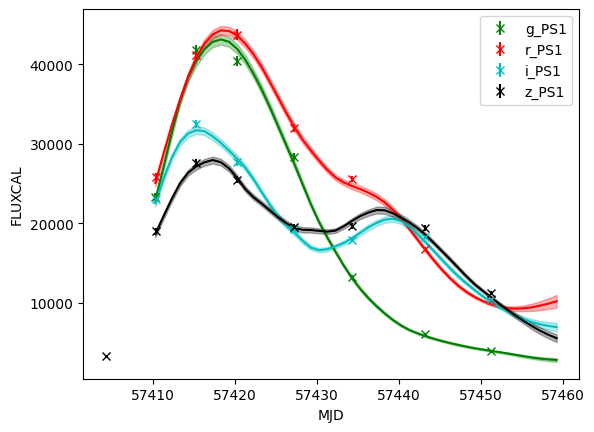

In [11]:
cs = ['g', 'r', 'c', 'k']
plot_t = t + meta['SEARCH_PEAKMJD']

for b_ind, b in enumerate(bands):
    b_data = lcdata[lcdata.FLT == b[0]]
    plt.errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)
    plt.plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    plt.fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])
plt.xlabel('MJD')
plt.ylabel('FLUXCAL')
plt.legend()
plt.show()

Note that these fluxes will incorporate the value and uncertainty of tmax. If you plot rest-frame phase, you may find that the maximum is not at t=0 days since tmax corresponds to a shift from some fiducidal time-of-maximum.

## Saving outputs

By default, the code will print a summary of the MCMC output and return the chains but won't save anything. If you want the outputs to be saved automatically, just set the kwarg `file_prefix` to whatever you want to call the outputs - the summary table and MCMC chains will respectively be saved as `{file_prefix}_summary.csv` and `{file_prefix}_chains.pkl` in the current location. This applies both to `model.fit()` and `model.fit_from_file()`.

If, for whatever reason, you don't want to print the summary table just set `print_summary=False`.